<h1>C4 Solution</h1>

<h3>Install and import</h3>

In [27]:
%%capture
import sys
!{sys.executable} -m pip install smdebug torch torchvision tqdm

In [2]:
import os
import boto3
import sagemaker
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs, ProfilerConfig, FrameworkProfile
from sagemaker.analytics import HyperparameterTuningJobAnalytics

<h3>Get the data and copy it to S3</h3>

In [3]:
#%%capture
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2023-05-30 19:50:13--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.121.80
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.121.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

100%[====================================>] 1,132,023,110 34.5MB/s   in 31s    

2023-05-30 19:50:43 (35.4 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.Af

In [5]:
!aws s3 cp dogImages s3://mlopscourse4/ --recursive

upload: dogImages/test/001.Affenpinscher/Affenpinscher_00047.jpg to s3://mlopscourse4/test/001.Affenpinscher/Affenpinscher_00047.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00078.jpg to s3://mlopscourse4/test/001.Affenpinscher/Affenpinscher_00078.jpg
upload: dogImages/test/002.Afghan_hound/Afghan_hound_00125.jpg to s3://mlopscourse4/test/002.Afghan_hound/Afghan_hound_00125.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg to s3://mlopscourse4/test/001.Affenpinscher/Affenpinscher_00023.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg to s3://mlopscourse4/test/001.Affenpinscher/Affenpinscher_00003.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00048.jpg to s3://mlopscourse4/test/001.Affenpinscher/Affenpinscher_00048.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg to s3://mlopscourse4/test/001.Affenpinscher/Affenpinscher_00036.jpg
upload: dogImages/test/002.Afghan_hound/Afghan_hound_00116.jpg to s3://ml

<h3>Set up parameters, estimator, and tuner</h3>

In [6]:
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128, 256, 512]),
}

role = sagemaker.get_execution_role()

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [11]:
estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name='pytorch_dog_hpo',
    role=role,
    framework_version="1.4.0",
    instance_count=1,
    instance_type="ml.m5.xlarge", # I don't know why ml.g4dn.xlarge instance gives me a ResourceLimitExceeded so I had to change it
    py_version='py3'
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=2,
    max_parallel_jobs=1,  # you once have one ml.g4dn.xlarge instance available
    objective_type=objective_type
)

<h3>Fit the tuner</h3>

In [12]:
os.environ['SM_CHANNEL_TRAINING']='s3://mlopscourse4/'
os.environ['SM_MODEL_DIR']='s3://mlopscourse4/model/'
os.environ['SM_OUTPUT_DATA_DIR']='s3://mlopscourse4/output/'
tuner.fit({"training": "s3://mlopscourse4/"})

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


<h3>Describe the tuning results</h3>


In [14]:
exp = HyperparameterTuningJobAnalytics(
  hyperparameter_tuning_job_name='pytorch-training-230530-1954')

jobs = exp.dataframe()

jobs.sort_values('FinalObjectiveValue', ascending=0)

batch_size  learning_rate                            TrainingJobName  \
1      "128"       0.012985  pytorch-training-230530-1954-001-d97fd7c5   
0      "128"       0.005985  pytorch-training-230530-1954-002-af2a6781   

  TrainingJobStatus  FinalObjectiveValue         TrainingStartTime  \
1         Completed                470.0 2023-05-30 19:56:02+00:00   
0         Completed                201.0 2023-05-30 20:19:31+00:00   

            TrainingEndTime  TrainingElapsedTimeSeconds  
1 2023-05-30 20:15:50+00:00                      1188.0  
0 2023-05-30 20:38:42+00:00                      1151.0

## Imp: If kernel dies, how to continue from a completed training job

In [3]:
BetterTrainingJobName='pytorch-training-230530-1954-002-af2a6781'
my_estimator = sagemaker.estimator.Estimator.attach(BetterTrainingJobName)
my_estimator.hyperparameters()
best_estimator=my_estimator


2023-05-30 20:38:44 Starting - Found matching resource for reuse
2023-05-30 20:38:44 Downloading - Downloading input data
2023-05-30 20:38:44 Training - Training image download completed. Training in progress.
2023-05-30 20:38:44 Uploading - Uploading generated training model
2023-05-30 20:38:44 Completed - Resource released due to keep alive period expiry


<h3>Prepare to perform Training on Best Estimator</h3>

In [10]:
# best_estimator=tuner.best_estimator()

In [5]:
best_estimator.hyperparameters()

{'_tuning_objective_metric': 'Test Loss',
 'batch_size': '"128"',
 'learning_rate': '0.005984803379518084',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch_dog_hpo-2023-05-30-19-54-42-311"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-126120491409/pytorch_dog_hpo-2023-05-30-19-54-42-311/source/sourcedir.tar.gz"'}

In [6]:
hyperparameters = {"batch_size": int(best_estimator.hyperparameters()['batch_size'].replace('"', '')), \
                   "learning_rate": best_estimator.hyperparameters()['learning_rate']}
hyperparameters

{'batch_size': 128, 'learning_rate': '0.005984803379518084'}

In [7]:
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

In [8]:
hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "1",
        "eval.save_interval": "1"
    }
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


<h2>Creating an Estimator</h2>

In [11]:
role = sagemaker.get_execution_role()

In [12]:
#adjust this cell to accomplish multi-instance training
estimator = PyTorch(
    entry_point='hpo.py',
    base_job_name='dog-pytorch',
    role=role,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    framework_version='1.4.0',
    py_version='py3',
    hyperparameters=hyperparameters,
    ## Debugger and Profiler parameters
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)

In [14]:
estimator.fit({"training": "s3://mlopscourse4/"}, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: dog-pytorch-2023-05-31-07-49-27-031


2023-05-31 07:49:28 Starting - Starting the training job...
2023-05-31 07:50:06 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
...
2023-05-31 07:50:37 Downloading - Downloading input data......
2023-05-31 07:51:38 Training - Training image download completed. Training in progress....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-05-31 07:51:48,800 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-05-31 07:51:48,804 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2023-05-31 07:51:48,815 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-05-31 07:51:48,817 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-05-31 07:51:49,002 sagemaker-c

<h2>Creating an Estimator - Multi-Instance Training,</h2>

In [19]:
###in this cell, create and fit an estimator using multi-instance training

#adjust this cell to accomplish multi-instance training
estimator = PyTorch(
    entry_point='hpo.py',
    base_job_name='dog-pytorch',
    role=role,
    instance_count=3,
    instance_type='ml.m5.xlarge',
    framework_version='1.4.0',
    py_version='py3',
    hyperparameters=hyperparameters,
    ## Debugger and Profiler parameters
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)
estimator.fit({"training": "s3://mlopscourse4/"}, wait=True)

<h2>Deployment</h2>

In [32]:
model_location=estimator.model_data


In [33]:
import sagemaker
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor


In [34]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [35]:
pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='infernce2.py',py_version='py3',
                             framework_version='1.4',
                             predictor_cls=ImagePredictor)

In [36]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')
# single instance trained endpoint name = 'pytorch-inference-2023-05-31-08-11-56-253'
# multi-instance trained endpoint name = 'pytorch-inference-2023-05-31-08-21-15-060'

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:sagemaker:Creating model with name: pytorch-inference-2023-05-31-08-21-14-393
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2023-05-31-08-21-15-060
INFO:sagemaker:Creating endpoint with name pytorch-inference-2023-05-31-08-21-15-060


----!

In [37]:
import requests
#request_dict={ "url": "https://cdn1-www.cattime.com/assets/uploads/2011/12/file_2744_british-shorthair-460x290-460x290.jpg" }
request_dict={ "url": "https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/20113314/Carolina-Dog-standing-outdoors.jpg" }

img_bytes = requests.get(request_dict['url']).content
type(img_bytes)

bytes

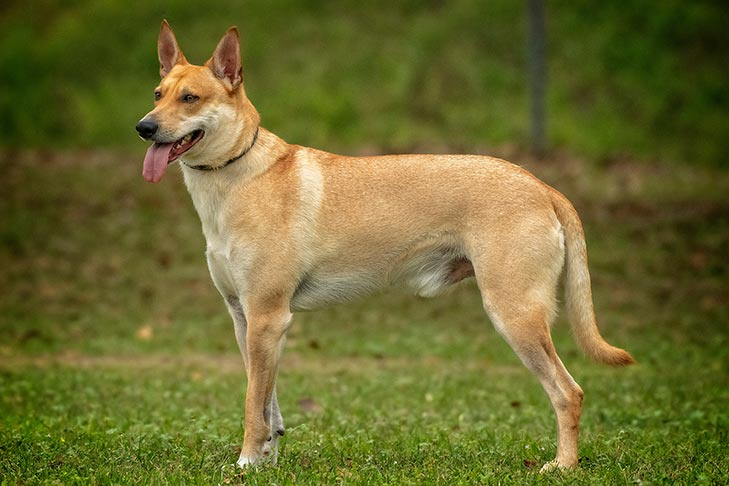

In [38]:
from PIL import Image
import io
Image.open(io.BytesIO(img_bytes))

In [39]:
response=predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})

In [40]:
response

[[-3.6260979175567627,
  -1.2132529020309448,
  -4.255741119384766,
  1.3438692092895508,
  1.1217502355575562,
  -3.0651607513427734,
  -2.179734468460083,
  -3.0293002128601074,
  -11.569900512695312,
  2.8207085132598877,
  2.1480119228363037,
  -1.6097121238708496,
  -1.5028672218322754,
  0.4057629108428955,
  -2.681805372238159,
  -3.2356643676757812,
  -4.162477970123291,
  -5.971139430999756,
  -3.140247344970703,
  3.6009483337402344,
  -2.468681812286377,
  3.1573963165283203,
  -7.289708614349365,
  -5.274064064025879,
  -8.121965408325195,
  -9.63962459564209,
  -1.7745790481567383,
  -4.470363616943359,
  -5.525793075561523,
  1.111715316772461,
  -0.7647328972816467,
  -3.8493881225585938,
  -6.389554500579834,
  -4.208932399749756,
  -8.93012523651123,
  -4.876474380493164,
  -4.127181529998779,
  -3.6812491416931152,
  -0.9846385717391968,
  -5.528894901275635,
  -4.002706050872803,
  -1.6588996648788452,
  3.0713257789611816,
  -4.449626922607422,
  0.5117375254631042,

In [41]:
import json
response2=predictor.predict(json.dumps(request_dict), initial_args={"ContentType": "application/json"})

In [42]:
response2

[[-3.6260979175567627,
  -1.2132529020309448,
  -4.255741119384766,
  1.3438692092895508,
  1.1217502355575562,
  -3.0651607513427734,
  -2.179734468460083,
  -3.0293002128601074,
  -11.569900512695312,
  2.8207085132598877,
  2.1480119228363037,
  -1.6097121238708496,
  -1.5028672218322754,
  0.4057629108428955,
  -2.681805372238159,
  -3.2356643676757812,
  -4.162477970123291,
  -5.971139430999756,
  -3.140247344970703,
  3.6009483337402344,
  -2.468681812286377,
  3.1573963165283203,
  -7.289708614349365,
  -5.274064064025879,
  -8.121965408325195,
  -9.63962459564209,
  -1.7745790481567383,
  -4.470363616943359,
  -5.525793075561523,
  1.111715316772461,
  -0.7647328972816467,
  -3.8493881225585938,
  -6.389554500579834,
  -4.208932399749756,
  -8.93012523651123,
  -4.876474380493164,
  -4.127181529998779,
  -3.6812491416931152,
  -0.9846385717391968,
  -5.528894901275635,
  -4.002706050872803,
  -1.6588996648788452,
  3.0713257789611816,
  -4.449626922607422,
  0.5117375254631042,

In [43]:
type(response2[0][0])

float

In [44]:
response2[0]

[-3.6260979175567627,
 -1.2132529020309448,
 -4.255741119384766,
 1.3438692092895508,
 1.1217502355575562,
 -3.0651607513427734,
 -2.179734468460083,
 -3.0293002128601074,
 -11.569900512695312,
 2.8207085132598877,
 2.1480119228363037,
 -1.6097121238708496,
 -1.5028672218322754,
 0.4057629108428955,
 -2.681805372238159,
 -3.2356643676757812,
 -4.162477970123291,
 -5.971139430999756,
 -3.140247344970703,
 3.6009483337402344,
 -2.468681812286377,
 3.1573963165283203,
 -7.289708614349365,
 -5.274064064025879,
 -8.121965408325195,
 -9.63962459564209,
 -1.7745790481567383,
 -4.470363616943359,
 -5.525793075561523,
 1.111715316772461,
 -0.7647328972816467,
 -3.8493881225585938,
 -6.389554500579834,
 -4.208932399749756,
 -8.93012523651123,
 -4.876474380493164,
 -4.127181529998779,
 -3.6812491416931152,
 -0.9846385717391968,
 -5.528894901275635,
 -4.002706050872803,
 -1.6588996648788452,
 3.0713257789611816,
 -4.449626922607422,
 0.5117375254631042,
 -9.635083198547363,
 -3.516343355178833,
 -

In [45]:
import torch
import numpy as np
np.argmax(response, 1)

array([66])

In [46]:
np.argmax(response2, 1)

array([66])